In [1]:
import pandas as pd
path = "../dataset/chapter_4/"

In [2]:
ulog = pd.read_csv(path + "use_log.csv")
cus = pd.read_csv(path + "customer_join.csv")
cus.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## 顧客のクラスタリング

In [3]:
c_cluster = cus[["mean", "median", "max", "min", "membership_period"]].copy() # 用いる変数を限定
# pandasはsetting_with_copy_warningを防ぐため, 常にコピーで運用
c_cluster.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [4]:
from sklearn.cluster import KMeans # k-means法
from sklearn.preprocessing import StandardScaler # 標準化
sc = StandardScaler()
c_cluster_sc = sc.fit_transform(c_cluster) # k-meansはユークリッド距離を用いるため, 標準化が必要
kmeans = KMeans(n_clusters = 4, random_state = 0) # k-meansではあらかじめクラスタ数を指定する必要がある
clusters = kmeans.fit(c_cluster_sc)
c_cluster["cluster"] = clusters.labels_
c_cluster.head()

,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [5]:
c_cluster.columns = ["月内平均", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
c_cluster.groupby("cluster").mean()

,月内平均,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


In [6]:
from sklearn.decomposition import PCA # 主成分分析
X = c_cluster_sc
pca = PCA(n_components = 2) # 採用する主成分数を指定
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = c_cluster["cluster"]
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,3
1,-0.707922,-1.799857,3
2,-1.061499,-1.659826,3
3,-1.160764,-1.810139,3
4,-2.017132,-1.670101,3


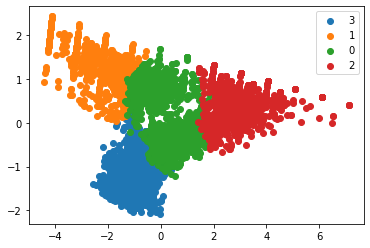

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in c_cluster["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"] == i].copy()
    plt.scatter(tmp[0], tmp[1], label = i)
plt.legend()

In [8]:
c_clus = pd.concat([c_cluster, cus], axis = 1)
c_clus.groupby(["cluster", "is_deleted"], as_index = False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [9]:
c_clus.groupby(["cluster", "is_deleted", "routine_flg"], as_index = False).count()[["cluster", "is_deleted", 
                                                                                   "routine_flg", "customer_id"]]

,cluster,is_deleted,routine_flg,customer_id
0,0,0,0,6
1,0,0,1,779
2,0,1,0,222
3,0,1,1,327
4,1,1,0,497
5,1,1,1,266
6,2,0,0,39
7,2,0,1,788
8,2,1,0,13
9,2,1,1,6


## 翌月の利用回数を予測

In [10]:
ulog["usedate"] = pd.to_datetime(ulog["usedate"])
ulog["年月"] = ulog["usedate"].dt.strftime("%Y%m")
ulog_months = ulog.groupby(["年月", "customer_id"], as_index = False).count()
ulog_months.rename(columns = {"log_id":"count"}, inplace = True)
del ulog_months["usedate"]
ulog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [11]:
year_months = list(ulog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)): #  特徴として6ヶ月分の利用回数を用いるため, 10月以降のデータのみ使用
    tmp = ulog_months.loc[ulog_months["年月"] == year_months[i]].copy()
    tmp.rename(columns = {"count":"count_pred"}, inplace = True)
    for j in range(1, 7):
        tmp_before = ulog_months.loc[ulog_months["年月"] == year_months[i-j]].copy()
        del tmp_before["年月"]
        tmp_before.rename(columns = {"count":"count_{}".format(j-1)}, inplace = True)
        tmp = pd.merge(tmp, tmp_before, on = "customer_id", how = "left")
    predict_data = pd.concat([predict_data, tmp], ignore_index = True) # ignore_index: indexふりなおし
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [12]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop = True) # drop: 元々のindexを削除
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [13]:
from dateutil.relativedelta import relativedelta
predict_data = pd.merge(predict_data, cus[["customer_id", "start_date"]], on = "customer_id", how = "left")
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format = "%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
period = []

In [14]:
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"].iloc[i], 
                         predict_data["start_date"].iloc[i])
    period.append(delta.years*12 + delta.months)
predict_data["period"] = period
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [18]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# 古くから入会しているuserは安定期に入っているため, 線形回帰による利用回数分析には用いない
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")]
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6135074684982971
0.5879558128450966


In [20]:
coef = pd.DataFrame({"feature_names": X.columns, "coefficient": model.coef_})
coef

,feature_names,coefficient
0,count_0,0.354671
1,count_1,0.184842
2,count_2,0.182488
3,count_3,0.166640
4,count_4,0.068844
5,count_5,0.056613
6,period,0.031119
